# Estimating Parameters

## Problem setup

We have a model and data we obtained from Minteq (equilibrium simulation of precipitation)

Model: $Conversion = \exp\big(-\frac{\epsilon}{oxalic acid}^{n_{DA}}\big)$

How do we obtain $\epsilon$ and $n_{DA}$?

In this tutorial we will learn:

1. Importing the necessary libraries
2. How to estimate parameters for 1 species
3. Plotting results
4. Estimating parameters for multiple species
5. Comparing results with data from UKy report


## 1. Import necessary libraries

We need to import pyomo (parmest), math  expressions and the Experiments class.

Additionally we need to import numpy for our math, matplotlib for plotting results and pandas to manage the data and the csv file

In [1]:
# Import Pyomo's math and parameter estimation libraries
import pyomo.environ as pyo
from pyomo.environ import exp, log
import pyomo.contrib.parmest.parmest as parmest
from pyomo.contrib.parmest.experiment import Experiment

# Import degrees of freedom function from IDAES for sanity check
from idaes.core.util.model_statistics import degrees_of_freedom

# Import data frame, math and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Estimating Parameters

### 2.1 Read data file and display

In [2]:
# Load data from csv
data = pd.read_csv("data_precipitation.csv")

# Display the dataset
display(data)

,Problem no.,Oxalate-2,La2-(Oxalate)3(s),Nd2-(Oxalate)3(s),Gd2(Oxalate)3(s),Ce2(Oxalate)3(s),Y2(Oxalate)3(s),Sm2(Oxalate)3(s),Sc2(Oxalate)3(s),Pr2(Oxalate)3(s),Dy2(Oxalate)3(s),Al-Oxalate(s),Ca-Oxalate:3H2O(s),FE-Oxalate(s)
0,1,0.000119,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
1,2,0.475119,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
2,3,0.950119,1.000000e-08,3.056268e-01,1.000000e-08,1.285681e-01,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
3,4,1.425119,1.000000e-08,6.732710e-01,1.000000e-08,5.948216e-01,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
4,5,1.900119,1.000000e-08,7.887279e-01,1.000000e-08,7.405005e-01,1.000000e-08,1.055505e-01,1.000000e-08,2.505410e-01,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,60,28.025119,9.997797e-01,9.999605e-01,9.999158e-01,1.000000e+00,9.994267e-01,9.999239e-01,9.824518e-01,9.999652e-01,9.994276e-01,1.000000e-08,9.784681e-01,9.940669e-01
60,61,28.500119,9.998315e-01,9.999737e-01,9.999326e-01,1.000000e+00,9.995831e-01,1.000000e+00,9.857651e-01,9.999652e-01,9.995782e-01,1.000000e-08,9.835986e-01,9.955222e-01
61,62,28.975119,9.999611e-01,9.999868e-01,9.999832e-01,1.000000e+00,9.998697e-01,1.000000e+00,9.951323e-01,1.000000e+00,9.999096e-01,1.000000e-08,9.902238e-01,9.987686e-01
62,63,29.450119,9.999870e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.999479e-01,1.000000e+00,9.975866e-01,1.000000e+00,9.999699e-01,1.000000e-08,9.978993e-01,9.993843e-01


### 2.2 Define the model

We will create a model that defines the precipitation conversion

In [3]:
def isotherm():

    # Todo: Create a ConcreteModel object
    m = pyo.ConcreteModel()

    # Set up variables of the model
    m.n_DA = pyo.Var(initialize=2)
    m.eps = pyo.Var(initialize=1)
    # Conversion variable
    m.CM = pyo.Var(initialize=0.1, bounds=(1e-8, 1))
    m.oxalic = pyo.Var(initialize=0.1, bounds=(1e-8, 30))
   
    # Set bounds on variables
    m.n_DA.setlb(1)
    m.n_DA.setub(5)

    m.eps.setlb(1)
    m.eps.setub(5)
    
    m.CM_rule = pyo.Constraint(
        expr=(m.CM == exp(-(m.eps/(m.oxalic))**m.n_DA)))

    # Fix variables to have 0 Degrees of Freedom (DoF)
    m.n_DA.fix(2)
    m.eps.fix(1)
    m.oxalic.fix(1.425119)
    
    # Return initialized flash model
    return m

### 2.3 Define Nd precipitation experiment 

In [4]:
# Create precipitation class
class PrecipitationExperiment(Experiment):

    # Define data 
    def __init__(self, data, experiment_number):
        self.data = data
        self.experiment_number = experiment_number
        self.data_i = data.iloc[experiment_number, :]
        self.model = None

    # Create a model based on the isotherm model
    def create_model(self):
        self.model = m = isotherm()
        return m

    # Define inputs and outputs of the experiment
    def finalize_model(self):
        m = self.model

        # Experiment inputs values
        m.oxalic = self.data_i['Oxalate-2'] 

        # Experiment output values
        m.CM = self.data_i['Nd2-(Oxalate)3(s)']

        return m

    # Label the parameters to be calculated
    def label_model(self):
        m = self.model

        m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_outputs.update(
            [
                (m.CM, self.data_i['Nd2-(Oxalate)3(s)']),
            ]
        )

        # Specify unknown parameters
        m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.unknown_parameters.update(
            (k, pyo.ComponentUID(k)) for k in [m.n_DA, m.eps]
        )

        return m

    def get_labeled_model(self):
        m = self.create_model()
        m = self.finalize_model()
        m = self.label_model()

        return m

### Test model and sanity check of Degrees of Freedom

In [5]:
# Testing the initialized model
test_data = {"oxalic": 1.425119}

m = isotherm()

m.oxalic = test_data["oxalic"]

# Check that degrees of freedom is 0
print("Degrees of Freedom = ", degrees_of_freedom(m))

Degrees of Freedom =  0


### 2.4 Finish setting up the experimet

Define Variable names and objective function in this case least squares method

In [6]:
variable_name = [
    "n_DA",
    "eps",
]

In [7]:
def SSE(m):
    expr = sum(((y - y_hat))**2 for y, y_hat in m.experiment_outputs.items())
    return expr * 1e4

### 2.5 Solve the parameter estimation model

In [8]:
# Initialize a parameter estimation object
exp_list = []
for i in range(data.shape[0]):
    exp_list.append(PrecipitationExperiment(data, i))

# Call solver
solver_options = {"tol": 1e-8}    

# Define Estimator
pest = parmest.Estimator(exp_list, obj_function=SSE, solver_options=solver_options, tee=True)

# Run parameter estimation using all data
obj_value, parameters = pest.theta_est()

Ipopt 3.13.2: tol=1e-08


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. S

### 2.6 Display results

In [9]:
print()
print("The values for the parameters are as follows:")
for k, v in parameters.items():
    print(k, "=", v)


The values for the parameters are as follows:
eps = 1.0103099354285994
n_DA = 2.4191371528476626


## 3 Plotting results

Next we will plot the results. We start by calculating conversion using our new calculated parameters

In [10]:
# Give calculated values to the variables
n_DA = {"Nd2-(Oxalate)3(s)":2.419137}
eps = {"Nd2-(Oxalate)3(s)":1.01030}

# Create an array for Oxalic acid dosage
oxalate = np.linspace(0.05, 30, 50)

# Create an empty list
Nd = []

#Caluclate conversion for Nd oxalate
for i in range(len(oxalate)):
    Ndi = exp(-(eps["Nd2-(Oxalate)3(s)"]/(oxalate[i]))**n_DA["Nd2-(Oxalate)3(s)"]) 
    
    #Store results
    Nd.append(Ndi)


Next we plot the results using matplotlib library.

<function matplotlib.pyplot.show(close=None, block=None)>

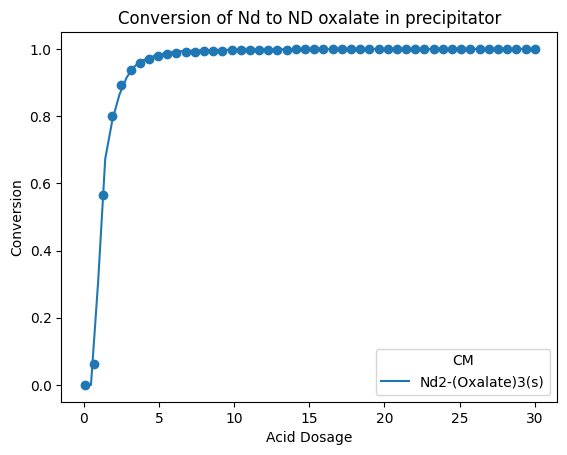

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(data["Oxalate-2"],data["Nd2-(Oxalate)3(s)"],label="Nd2-(Oxalate)3(s)")
ax.scatter(oxalate,Nd)

plt.xlabel('Acid Dosage')
plt.ylabel('Conversion')
plt.title('Conversion of Nd to ND oxalate in precipitator')

ax.legend(title='CM')
plt.show

Finally lets create a parity plot 

In [12]:
# Defining array with experimental acid dosage
oxalic_acid_pp = data["Oxalate-2"].to_numpy()

# Creating empty list to store results
Nd_pp = []

#Re run equation to calculate conversion at experimental acid dosage
for i in range(len(oxalic_acid_pp)):
    Ndi_pp = exp(-(eps["Nd2-(Oxalate)3(s)"]/(oxalic_acid_pp[i]))**n_DA["Nd2-(Oxalate)3(s)"]) 

    # Store results
    Nd_pp.append(Ndi_pp)

Create and display parity plot

<function matplotlib.pyplot.show(close=None, block=None)>

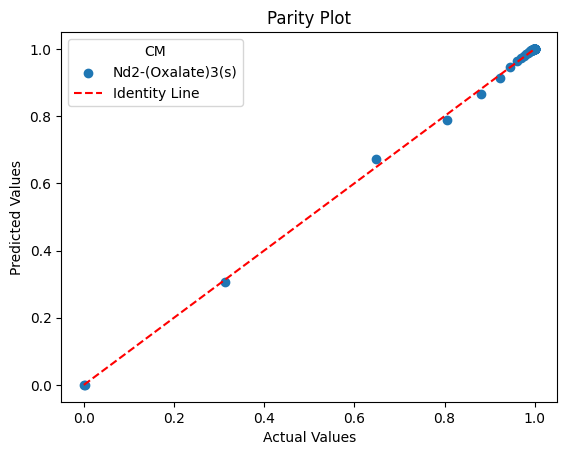

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(Nd_pp,data["Nd2-(Oxalate)3(s)"],label="Nd2-(Oxalate)3(s)")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Identity Line')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot')

ax.legend(title='CM')
plt.show

## 5 Estimating multiple species

## 5.1 Create a new model with multiple species 

In [14]:
def isotherm_multiple():

    # Todo: Create a ConcreteModel object
    m = pyo.ConcreteModel()

    # Create list of oxalates present
    m.oxalates = [
        "La2-(Oxalate)3(s)",
                "Nd2-(Oxalate)3(s)",
                "Gd2(Oxalate)3(s)",
                "Ce2(Oxalate)3(s)",
                "Y2(Oxalate)3(s)",
                "Sm2(Oxalate)3(s)",
                "Sc2(Oxalate)3(s)",
                "Pr2(Oxalate)3(s)",
                "Dy2(Oxalate)3(s)",
                 ]

    # Dictionaries with initial values to our parameters
    # parameter based on pH 1.5
    eps_init = {
            "Sc2(Oxalate)3(s)": 6.4,
            "Y2(Oxalate)3(s)": 4.5,
            "La2-(Oxalate)3(s)": 4.3,
            "Ce2(Oxalate)3(s)": 1.1,
            "Pr2(Oxalate)3(s)": 2.09,
            "Nd2-(Oxalate)3(s)": 1,
            "Sm2(Oxalate)3(s)": 2.3,
            "Gd2(Oxalate)3(s)": 3.1,
            "Dy2(Oxalate)3(s)": 4.9,
    }
        
    # parameter based on pH 1.5
    N_D_init = {
            "Sc2(Oxalate)3(s)": 6,
            "Y2(Oxalate)3(s)": 4,
            "La2-(Oxalate)3(s)": 4,
            "Ce2(Oxalate)3(s)": 2,
            "Pr2(Oxalate)3(s)": 3,
            "Nd2-(Oxalate)3(s)": 2,
            "Sm2(Oxalate)3(s)": 3,
            "Gd2(Oxalate)3(s)": 4,
            "Dy2(Oxalate)3(s)": 4,
        }
        
    # Create variables for parmeters and variables, note they are indexed by the previously created spedies list
    m.n_DA = pyo.Var(m.oxalates, initialize=eps_init, bounds=(1, 7))
    m.eps = pyo.Var(m.oxalates, initialize=N_D_init, bounds=(1, 7))
    m.CM = pyo.Var(m.oxalates, initialize=0.1, bounds=(1e-8, 1))
    m.oxalic = pyo.Var(initialize=0.1, bounds=(1e-8, 30))

    # Create constraint now indexed by our list
    @m.Constraint(
    m.oxalates,
    doc="Conversion constraint",
    )
    def conversion_constraint(blk, t):
        return (m.CM[t] == exp(-(m.eps[t]/(m.oxalic))**m.n_DA[t]))
    
    # Fix variables to set up square problem
    m.n_DA["La2-(Oxalate)3(s)"].fix(4.9)
    m.n_DA["Nd2-(Oxalate)3(s)"].fix(2)
    m.n_DA["Gd2(Oxalate)3(s)"].fix(4.2)
    m.n_DA["Ce2(Oxalate)3(s)"].fix(2.7)
    m.n_DA["Y2(Oxalate)3(s)"].fix(4.7)
    m.n_DA["Sm2(Oxalate)3(s)"].fix(3.7)
    m.n_DA["Sc2(Oxalate)3(s)"].fix(2.3)
    m.n_DA["Pr2(Oxalate)3(s)"].fix(3.4)
    m.n_DA["Dy2(Oxalate)3(s)"].fix(4.7)
                 
    m.eps["La2-(Oxalate)3(s)"].fix(4.3)
    m.eps["Nd2-(Oxalate)3(s)"].fix(1)
    m.eps["Gd2(Oxalate)3(s)"].fix(3.1)
    m.eps["Ce2(Oxalate)3(s)"].fix(1.1)
    m.eps["Y2(Oxalate)3(s)"].fix(4.5)
    m.eps["Sm2(Oxalate)3(s)"].fix(2.3)
    m.eps["Sc2(Oxalate)3(s)"].fix(6.4)
    m.eps["Pr2(Oxalate)3(s)"].fix(2.1)
    m.eps["Dy2(Oxalate)3(s)"].fix(4.9)  
    
    m.oxalic.fix(1.425119)
    
    # Return initialized flash model
    return m

## 5.2 Define the experiments again with multiple components

In [15]:
class PrecipitationMultipleExperiment(Experiment):

    def __init__(self, data, experiment_number):
        self.data = data
        self.experiment_number = experiment_number
        self.data_i = data.iloc[experiment_number, :]
        self.model = None

    def create_model(self):
        self.model = m = isotherm_multiple()
        return m

    def finalize_model(self):
        m = self.model

        # Experiment inputs values
        m.oxalic = self.data_i['Oxalate-2'] 

        # Experiment output values
        m.CM["La2-(Oxalate)3(s)"] = self.data_i["La2-(Oxalate)3(s)"]
        m.CM["Nd2-(Oxalate)3(s)"] = self.data_i["Nd2-(Oxalate)3(s)"]
        m.CM["Gd2(Oxalate)3(s)"] = self.data_i["Gd2(Oxalate)3(s)"]
        m.CM["Ce2(Oxalate)3(s)"] = self.data_i["Ce2(Oxalate)3(s)"]
        m.CM["Y2(Oxalate)3(s)"] = self.data_i["Y2(Oxalate)3(s)"]
        m.CM["Sm2(Oxalate)3(s)"] = self.data_i["Sm2(Oxalate)3(s)"]
        m.CM["Sc2(Oxalate)3(s)"] = self.data_i["Sc2(Oxalate)3(s)"]
        m.CM["Pr2(Oxalate)3(s)"] = self.data_i["Pr2(Oxalate)3(s)"]
        m.CM["Dy2(Oxalate)3(s)"] = self.data_i["Dy2(Oxalate)3(s)"]

        return m

    def label_model(self):
        m = self.model

        m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_outputs.update(
            [
                (m.CM["La2-(Oxalate)3(s)"], self.data_i["La2-(Oxalate)3(s)"]),
                (m.CM["Nd2-(Oxalate)3(s)"], self.data_i["Nd2-(Oxalate)3(s)"]),
                (m.CM["Gd2(Oxalate)3(s)"], self.data_i["Gd2(Oxalate)3(s)"]),
                (m.CM["Ce2(Oxalate)3(s)"], self.data_i["Ce2(Oxalate)3(s)"]),
                (m.CM["Y2(Oxalate)3(s)"], self.data_i["Y2(Oxalate)3(s)"]),
                (m.CM["Sm2(Oxalate)3(s)"], self.data_i["Sm2(Oxalate)3(s)"]),
                (m.CM["Sc2(Oxalate)3(s)"], self.data_i["Sc2(Oxalate)3(s)"]),
                (m.CM["Pr2(Oxalate)3(s)"], self.data_i["Pr2(Oxalate)3(s)"]),
                (m.CM["Dy2(Oxalate)3(s)"], self.data_i["Dy2(Oxalate)3(s)"]),
            ]
        )

        m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.unknown_parameters.update(
            (k, pyo.ComponentUID(k)) for k in [
                m.n_DA["La2-(Oxalate)3(s)"],
                m.n_DA["Nd2-(Oxalate)3(s)"],
                m.n_DA["Gd2(Oxalate)3(s)"],
                m.n_DA["Ce2(Oxalate)3(s)"],
                m.n_DA["Y2(Oxalate)3(s)"],
                m.n_DA["Sm2(Oxalate)3(s)"],
                m.n_DA["Sc2(Oxalate)3(s)"],
                m.n_DA["Pr2(Oxalate)3(s)"],
                m.n_DA["Dy2(Oxalate)3(s)"],
                m.eps["La2-(Oxalate)3(s)"],
                m.eps["Nd2-(Oxalate)3(s)"],
                m.eps["Gd2(Oxalate)3(s)"],
                m.eps["Ce2(Oxalate)3(s)"],
                m.eps["Y2(Oxalate)3(s)"],
                m.eps["Sm2(Oxalate)3(s)"],
                m.eps["Sc2(Oxalate)3(s)"],
                m.eps["Pr2(Oxalate)3(s)"],
                m.eps["Dy2(Oxalate)3(s)"]
              ]
        )

        return m

    def get_labeled_model(self):
        m = self.create_model()
        m = self.finalize_model()
        m = self.label_model()

        return m

Sanity check test

In [16]:
from idaes.core.util.model_statistics import degrees_of_freedom

# Testing the initialized model
test_data = {"oxalic": 1.425119}

m1 = isotherm_multiple()

m1.oxalic = test_data["oxalic"]

# Check that degrees of freedom is 0
print(degrees_of_freedom(m1))

0


Define the new large array of variables

In [17]:
variable_name = [
    "n_DA['La2-(Oxalate)3(s)']",
    "n_DA['Nd2-(Oxalate)3(s)']",
    "n_DA['Gd2(Oxalate)3(s)']",
    "n_DA['Ce2(Oxalate)3(s)']",
    "n_DA['Y2(Oxalate)3(s)']",
    "n_DA['Sm2(Oxalate)3(s)']",
    "n_DA['Sc2(Oxalate)3(s)']",
    "n_DA['Pr2(Oxalate)3(s)']",
    "n_DA['Dy2(Oxalate)3(s)']",
    "eps['La2-(Oxalate)3(s)']",
    "eps['Nd2-(Oxalate)3(s)']",
    "eps['Gd2(Oxalate)3(s)']",
    "eps['Ce2(Oxalate)3(s)']",
    "eps['Y2(Oxalate)3(s)']",
    "eps['Sm2(Oxalate)3(s)']",
    "eps['Sc2(Oxalate)3(s)']",
    "eps['Pr2(Oxalate)3(s)']",
    "eps['Dy2(Oxalate)3(s)']"
]

## 5.3 Solve the model

In [18]:
# Initialize a parameter estimation object
exp_list1 = []
for i in range(data.shape[0]):
    exp_list1.append(PrecipitationMultipleExperiment(data, i))

solver_options = {"tol": 1e-8}    
    
pest = parmest.Estimator(exp_list1, obj_function=SSE, solver_options=solver_options, tee=True)

# Run parameter estimation using all data
obj_value, parameters = pest.theta_est()

Ipopt 3.13.2: tol=1e-08


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. S

Solve model

In [19]:
print()
print("The values for the parameters are as follows:")
for k, v in parameters.items():
    print(k, "=", v)


The values for the parameters are as follows:
eps['Dy2(Oxalate)3(s)'] = 4.860832168523546
n_DA['La2-(Oxalate)3(s)'] = 4.634016954794473
n_DA['Dy2(Oxalate)3(s)'] = 4.731066404217136
eps['Sc2(Oxalate)3(s)'] = 6.4203091084692625
eps['Sm2(Oxalate)3(s)'] = 2.296176406330589
n_DA['Pr2(Oxalate)3(s)'] = 3.4436450505150273
n_DA['Gd2(Oxalate)3(s)'] = 4.1995182419503605
eps['Ce2(Oxalate)3(s)'] = 1.1884894090354285
n_DA['Ce2(Oxalate)3(s)'] = 2.7372386583928616
eps['Nd2-(Oxalate)3(s)'] = 1.0103099635296546
n_DA['Sm2(Oxalate)3(s)'] = 3.7201647849559016
eps['Gd2(Oxalate)3(s)'] = 3.0727625138333163
n_DA['Sc2(Oxalate)3(s)'] = 2.3606191763064435
eps['La2-(Oxalate)3(s)'] = 4.371711269573396
eps['Y2(Oxalate)3(s)'] = 4.551786856542047
eps['Pr2(Oxalate)3(s)'] = 2.0960477121902463
n_DA['Nd2-(Oxalate)3(s)'] = 2.419137224454658
n_DA['Y2(Oxalate)3(s)'] = 4.674032744736154


## 5.4 Calculate equation with new obtained parameters

In [20]:
oxalate = np.linspace(0.05, 30, 50)

La = []
Nd = []
Gd = []
Ce = []
Y = []
Sm = []
Sc = []
Pr = []
Dy = []
Ca = []
Fe = []

n_DA = {"La2-(Oxalate)3(s)":4.6340,
        "Nd2-(Oxalate)3(s)":2.4191,
        "Gd2(Oxalate)3(s)":4.1995,
        "Ce2(Oxalate)3(s)":2.737238,
        "Y2(Oxalate)3(s)":4.67403,
        "Sm2(Oxalate)3(s)":3.7201,
        "Sc2(Oxalate)3(s)":2.3606,
        "Pr2(Oxalate)3(s)":3.44364,
        "Dy2(Oxalate)3(s)":4.73106,
        "Ca-Oxalate:3H2O(s)":4.45302,
        "FE-Oxalate(s)":3.6495}

eps = {"La2-(Oxalate)3(s)":4.3717,
        "Nd2-(Oxalate)3(s)":1.01030,
        "Gd2(Oxalate)3(s)":3.07276,
        "Ce2(Oxalate)3(s)":1.18848,
        "Y2(Oxalate)3(s)":4.6740,
        "Sm2(Oxalate)3(s)":2.296176,
        "Sc2(Oxalate)3(s)":6.42030,
        "Pr2(Oxalate)3(s)":2.09604,
        "Dy2(Oxalate)3(s)":4.8608,
        "Ca-Oxalate:3H2O(s)":14.49274,
        "FE-Oxalate(s)":8.659561}


for i in range(len(oxalate)):
    Lai = exp(-(eps["La2-(Oxalate)3(s)"]/(oxalate[i]))**n_DA["La2-(Oxalate)3(s)"])
    Ndi = exp(-(eps["Nd2-(Oxalate)3(s)"]/(oxalate[i]))**n_DA["Nd2-(Oxalate)3(s)"]) 
    Gdi = exp(-(eps["Gd2(Oxalate)3(s)"]/(oxalate[i]))**n_DA["Gd2(Oxalate)3(s)"]) 
    Cei = exp(-(eps["Ce2(Oxalate)3(s)"]/(oxalate[i]))**n_DA["Ce2(Oxalate)3(s)"]) 
    Yi = exp(-(eps["Y2(Oxalate)3(s)"]/(oxalate[i]))**n_DA["Y2(Oxalate)3(s)"]) 
    Smi = exp(-(eps["Sm2(Oxalate)3(s)"]/(oxalate[i]))**n_DA["Sm2(Oxalate)3(s)"]) 
    Sci = exp(-(eps["Sc2(Oxalate)3(s)"]/(oxalate[i]))**n_DA["Sc2(Oxalate)3(s)"]) 
    Pri = exp(-(eps["Pr2(Oxalate)3(s)"]/(oxalate[i]))**n_DA["Pr2(Oxalate)3(s)"]) 
    Dyi = exp(-(eps["Dy2(Oxalate)3(s)"]/(oxalate[i]))**n_DA["Dy2(Oxalate)3(s)"]) 
    Cai = exp(-(eps["Ca-Oxalate:3H2O(s)"]/(oxalate[i]))**n_DA["Ca-Oxalate:3H2O(s)"]) 
    Fei = exp(-(eps["FE-Oxalate(s)"]/(oxalate[i]))**n_DA["FE-Oxalate(s)"])
    
    La.append(Lai)
    Nd.append(Ndi)
    Gd.append(Gdi)
    Ce.append(Cei)
    Y.append(Yi)
    Sm.append(Smi)
    Sc.append(Sci)
    Pr.append(Pri)
    Dy.append(Dyi)
    Ca.append(Cai)
    Fe.append(Fei)

## 5.5 Plot new results

<function matplotlib.pyplot.show(close=None, block=None)>

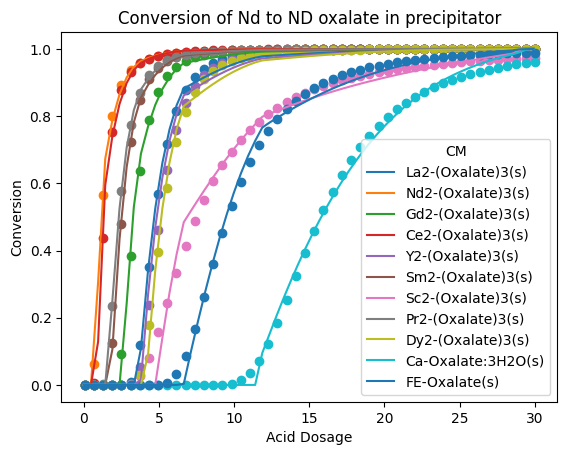

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(data["Oxalate-2"],data["La2-(Oxalate)3(s)"],label="La2-(Oxalate)3(s)")
ax.plot(data["Oxalate-2"],data["Nd2-(Oxalate)3(s)"],label="Nd2-(Oxalate)3(s)")
ax.plot(data["Oxalate-2"],data["Gd2(Oxalate)3(s)"],label="Gd2-(Oxalate)3(s)")
ax.plot(data["Oxalate-2"],data["Ce2(Oxalate)3(s)"],label="Ce2-(Oxalate)3(s)")
ax.plot(data["Oxalate-2"],data["Y2(Oxalate)3(s)"],label="Y2-(Oxalate)3(s)")
ax.plot(data["Oxalate-2"],data["Sm2(Oxalate)3(s)"],label="Sm2-(Oxalate)3(s)")
ax.plot(data["Oxalate-2"],data["Sc2(Oxalate)3(s)"],label="Sc2-(Oxalate)3(s)")
ax.plot(data["Oxalate-2"],data["Pr2(Oxalate)3(s)"],label="Pr2-(Oxalate)3(s)")
ax.plot(data["Oxalate-2"],data["Dy2(Oxalate)3(s)"],label="Dy2-(Oxalate)3(s)")
ax.plot(data["Oxalate-2"],data["Ca-Oxalate:3H2O(s)"],label="Ca-Oxalate:3H2O(s)")
ax.plot(data["Oxalate-2"],data["FE-Oxalate(s)"],label="FE-Oxalate(s)")
ax.scatter(oxalate,La)
ax.scatter(oxalate,Nd)
ax.scatter(oxalate,Gd)
ax.scatter(oxalate,Ce)
ax.scatter(oxalate,Y)
ax.scatter(oxalate,Sm)
ax.scatter(oxalate,Sc)
ax.scatter(oxalate,Pr)
ax.scatter(oxalate,Dy)
ax.scatter(oxalate,Ca)
ax.scatter(oxalate,Fe)

plt.xlabel('Acid Dosage')
plt.ylabel('Conversion')
plt.title('Conversion of Nd to ND oxalate in precipitator')

ax.legend(title='CM')
plt.show

## 5.6 Compare results wit UKy report 

Steven Keim, "Production of salable rare earths products from coal and coal byproducts in the U.S.
using advanced separation processes", 2019

In [22]:
oxalate1 = 6.4 

La1 = []
Nd1 = []
Gd1 = []
Ce1 = []
Y1 = []
Sm1 = []
Sc1 = []
Pr1 = []
Dy1 = []

La1 = exp(-(eps["La2-(Oxalate)3(s)"]/(oxalate1))**n_DA["La2-(Oxalate)3(s)"])
Nd1 = exp(-(eps["Nd2-(Oxalate)3(s)"]/(oxalate1))**n_DA["Nd2-(Oxalate)3(s)"]) 
Gd1 = exp(-(eps["Gd2(Oxalate)3(s)"]/(oxalate1))**n_DA["Gd2(Oxalate)3(s)"]) 
Ce1 = exp(-(eps["Ce2(Oxalate)3(s)"]/(oxalate1))**n_DA["Ce2(Oxalate)3(s)"]) 
Y1 = exp(-(eps["Y2(Oxalate)3(s)"]/(oxalate1))**n_DA["Y2(Oxalate)3(s)"]) 
Sm1 = exp(-(eps["Sm2(Oxalate)3(s)"]/(oxalate1))**n_DA["Sm2(Oxalate)3(s)"]) 
Sc1 = exp(-(eps["Sc2(Oxalate)3(s)"]/(oxalate1))**n_DA["Sc2(Oxalate)3(s)"]) 
Pr1 = exp(-(eps["Pr2(Oxalate)3(s)"]/(oxalate1))**n_DA["Pr2(Oxalate)3(s)"]) 
Dy1 = exp(-(eps["Dy2(Oxalate)3(s)"]/(oxalate1))**n_DA["Dy2(Oxalate)3(s)"]) 
Ca1 = exp(-(eps["Ca-Oxalate:3H2O(s)"]/(oxalate1))**n_DA["Ca-Oxalate:3H2O(s)"]) 
Fe1 = exp(-(eps["FE-Oxalate(s)"]/(oxalate1))**n_DA["FE-Oxalate(s)"])

bsarcm = np.array([La1,Nd1,Gd1,Ce1,Y1,Sm1,Sc1,Pr1,Dy1,Ca1,Fe1])

## 5.7 Plot results

<function matplotlib.pyplot.show(close=None, block=None)>

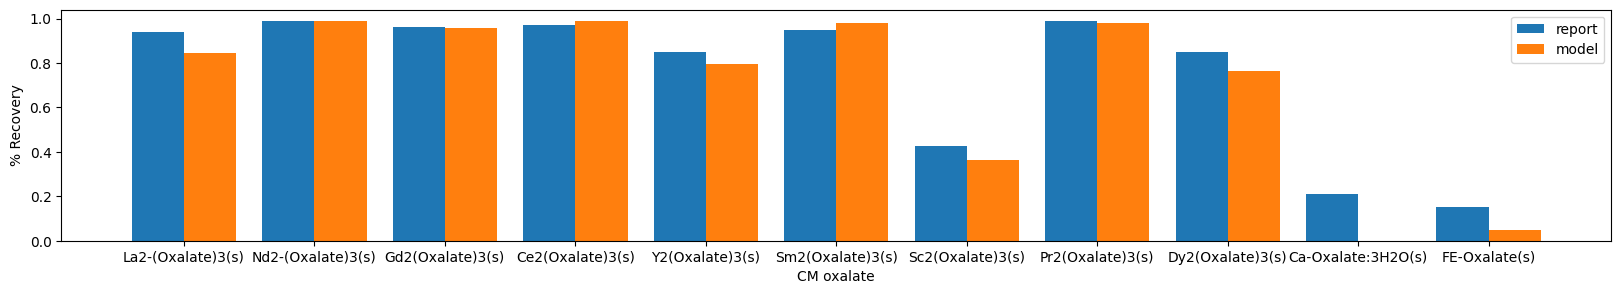

In [23]:
critical_minerals = [
    "La2-(Oxalate)3(s)", 
    "Nd2-(Oxalate)3(s)", 
    "Gd2(Oxalate)3(s)", 
    "Ce2(Oxalate)3(s)", 
    "Y2(Oxalate)3(s)", 
    "Sm2(Oxalate)3(s)", 
    "Sc2(Oxalate)3(s)", 
    "Pr2(Oxalate)3(s)", 
    "Dy2(Oxalate)3(s)",
    "Ca-Oxalate:3H2O(s)",
    "FE-Oxalate(s)"]

datacm = [0.94,0.99,0.96,0.97,0.85,0.95,0.4281,0.99,0.85,0.21,0.15]
datax = [6.4,6.4,6.4,6.4,6.4,6.4,6.4,6.4,6.4,6.4,6.4]

X_axis = np.arange(len(critical_minerals)) 

fig = plt.figure(figsize=[20,3])
ax = fig.add_subplot(1, 1, 1)

ax.bar(X_axis - 0.2,datacm, 0.4, label = 'report')
ax.bar(X_axis + 0.2,bsarcm, 0.4, label = 'model')

plt.xticks(X_axis, critical_minerals)
plt.xlabel("CM oxalate") 
plt.ylabel("% Recovery") 
plt.legend()
plt.show